# **Case Study 5**
## Automated Firewall Rule Action Predictor
  
  
---


# Team DEAN:
#### **D**avid Wei | **E**dward Roske | **A**dam Canton | **N**eil Benson

<a name="BusinessUnderstanding"></a>
# **Business Understanding** 
*   **Problem**: Company ABC (not their real name) is currently at a stage of growth where it's receiving a tremendous amount of public notice and attention. Due to the recent limelight in the past few months, the company has been experiencing increased web traffic on their network. The IT Admin team has expressed that its existing firewall policies were not designed to adequately handle and keep up with the current level of requests coming in and has expressed the vulnerability this presents to the company. How can we minimize potentially destructive traffic from entering our network?   
*   **Objective**: Using historical firewall data provided by Company ABC's internal IT Admin team, the data science team was tasked with building, tuning, and developing what the company called "the best, most advanced model." The team took this to mean a highly accurate and efficient model to tackle new incoming requests automatically on the fly with minimal to no additional overhead costs. Further, Company ABC's exact words to the team were to "use SVM and SGD to attempt to model and predict the class of an internet connection request" and that is exactly what our classifier set out to do. With our model, incoming requests would be allowed or denied based on what we had done historically.
*   **Why is this important?**: As network requirements change, security policy often requires updates to accommodate such changes but it is no easy task given the current scale at which these policies need to be updated. To ensure the continued safety and compliance of Company ABC's privacy and security, the ability to automatically accept or deny requests without significant overhead is crucial to the future growth and development of the company. With [ransomware attacks on the rise](https://theconversation.com/the-increase-in-ransomware-attacks-during-the-covid-19-pandemic-may-lead-to-a-new-internet-162490), stopping nefarious traffic from getting into the network could also result in significant savings [(70 million dollars, in this case)](https://www.cbsnews.com/news/ransomware-hackers-70-million-revil/). 

# **Data Evaluation & Engineering**
*   **Summary of Data**: The data contained a .CSV file of historical logs of incoming requests, the request properties (bytes sent, packets sent, etc.), and the "Action" of how that request was handled (allowed, denied, etc.). There were 65,532 observations in the data. There were significant [data issues detailed below](#DataIssues) though none that the team was unable to surmount. Further information on the data can be found in the [Exploratory Data Analysis](#EDA) section later in the report.
*   **Feature Engineering**: The team found that almost all of the data provided a granular level view into the details of incoming requests. As such, the team decided that no additional feature engineering was required with the exception of the Class to be predicted. To clarify, there are four values for the response variable **Action**:  
    * **Allow**: *Allow* the request to proceed.  
    * **Deny**: *Do not allow* the request to proceed and *let* the incoming requester know that the request was denied.
    * **Drop**: *Do not allow* the request to proceed and *do not let* the incoming requester know that the request was denied.  
    * **Reset-Both**: *Do not allow* the request to proceed and reset the request for both the sender and the receiver.  
*   The team felt that the Action really fell into two categories based on what the customer wanted: "Allow" or "Do Not Allow", so Deny, Drop, and Reset-Both were combined together into just "Deny". This simplified the problem into one of binary classification. In addition, by viewing the value counts of the last Action category of 'reset-both', it was found that with such a diminutive volume of that category (50 records), it could easily be generalized to the broader category of 'Deny'.  
<a name="DataIssues"></a>
*   **Data Issues**: The team found that there were 4 major areas of data issues: duplicate data, significant outliers, correlated attributes, and missing data. 
    * **Duplicate Data**: Addressing the first issue of [duplicate data](#Duplicates), it was observed that 12% of the total dataset contained exactly the same values. Interestingly, when looking more closely at the duplicate records, it was found that almost all (98%) of those duplicates were "Deny" type firewall actions. The team chose to remove these duplicates with the knowledge that it's often the case where multiple malicious requests are sent if the original request was rejected. While these repeated, rapid requests can be a sign of a [denial of service attack](https://www.paloaltonetworks.com/cyberpedia/what-is-a-denial-of-service-attack-dos), identifying these hacking attempts was not the objective of this project.
    * **Outliers**: When the team observed the outliers of the original logs as shown in the [boxplots](#Outliers), it was observed that a small percentage of requests sent had significantly higher values. However, when observing the distribution of the outliers, the team found that it only accounted for 10% of the total data with marginal differences at even higher quartiles (95th). Given how small of a sample size these outliers occupied, the team removed them in favor of preserving a more normal distribution as visualized in the 90th vs 95th [quartile outlier boxplots](#RemoveOutliers). If these values had been left in, the model would attempt to factor in these edge-case outliers at the potential expense of the more relevant traffic.
    * **Variables Not Needed (Correlated Data)**: When observing the relationships of each of the firewall attributes, the team detected high correlations (corr > .9) between the Bytes, Packets and their individual sent and received attributes. The team speculated that the request 'Byte' and 'Packet' values were actually sums of their individual components [which tested to be true](#Testing). As a result, the team preserved only the individual attributes and removed the total sums which coincidentally, also removed any remaining high correlations present as shown in the before and after [Correlation Heatmaps](#Correlations) section. 
    *   **Missing Values**: At first glance, it seems that there is no missing data: all of the properties of incoming requests were populated numerical values with no apparent empty data (as demonstrated [in the visual](#MissingViz)). However, upon [further analysis](#MissingData) it was found 173 records (less than 1% of the total data) contained '0' for both Source and Destination ports. Upon further inspection as to what port '0' was, the team learned that these port values are actually defined as 'reserved ports' which per the Internet Assigned Numbers Authority (IANA), should be not be a used system port but rather a wildcard placeholder ([source](https://www.lifewire.com/port-0-in-tcp-and-udp-818145)). As a result, the team removed all records where both the Source and Destination Ports were 0 as it did not serve any real purpose for firewall policy making.
*   **Final Data Set**: The [final dataset](#FinalDF) used for modeling includes all data that was left after removing any duplicates, outliers (10th percentile), correlated attributes and missing data. This reduced the total size of data from 65,532 to 46,905, a roughly 28% decrease. The final cleaned dataset was then exported and re-loaded in according to versioning for ease of use. 
*   **Exploratory Data Analysis**: [Very thorough EDA](#EDA) was performed for this case as the data contained many discrepancies that were not evident at first glance. Most of the EDA was directed towards addressing the Data Issues discussed above in this section in greater detail and confirming whether any of the nuances the team speculated may exist in the data were true or not. 
*   **Assumptions and Other Relevant Notes**: The primary assumption the team made when preparing the models was that the data was not serially correlated. Meaning, each request was evaluated on its own and not, for example, "is this the 7th request we've gotten from the same port in the last second?" While this analysis may be helpful, there was no timestamp in the logs. The team also assumed that the Action variables were correctly coded, because these were the responses used to train the model.

# **Model Preparations**
*   **Proposed Methods**: Though the client only requested a SVM (Support Vector Machine) and SGD (Stochastic Gradient Descent) model, the team actually created multiple classifiers (listed below) to compare their performances. This initial model comparison was done using the PyCaret library not only to provide alternative approaches to the problem at hand but to more importantly gauge how well the client's requested model compared to other potential methods and models. The full table with color-coding of the best performing models can be seen in the [PyCaret Models](#PyCaretModels) section.<br>  
  
|Model Name|Accuracy|Recall|Precision|F1|  
|-----|-----|-----|-----|-----|  
|**Random Forest Classifier**|**0.9999**|**0.9998**|0.9998|**0.9998**|  
|**Ada Boost Classifier**|0.9998|0.9997|0.9994|0.9995|  
|**Gradient Boosting Classifier**|0.9998|0.9995|0.9995|0.9995|  
|**Extra Trees Classifier**|0.9998|0.9995|0.9999|0.9997|  
|**Extreme Gradient Boosting**|0.9998|0.9995|0.9997|0.9996|  
|**Light Gradient Boosting Machine**|0.9998|0.9998|0.9995|0.9997|  
|**CatBoost Classifier**|0.9998|0.9997|0.9994|0.9995|  
|**Decision Tree Classifier**|0.9997|0.9995|0.9993|0.9994|  
|**Logistic Regression**|0.9988|0.9968|0.9986|0.9977|  
|**Naive Bayes**|0.9974|0.9930|0.9973|0.9951|  
|**K Neighbors Classifier**|0.9970|0.9943|0.9947|0.9945|  
|**Quadratic Discriminant Analysis**|0.9953|0.9824|**1.0000**|0.9907|  
|**SVM - Linear Kernel**|0.9780|0.9948|0.9295|0.9607|  
|**Ridge Classifier**|0.9543|0.9947|0.8574|0.9209|  
|**Linear Discriminant Analysis**|0.9441|0.9952|0.8300|0.9051|  

*   **Appropriateness**: By converting the nature of the client's problem into a Binary Classification method to better match the client's request through feature engineering, this allows the classification model to be more applicable to the problem at hand without sacrificing the original values themselves. Additionally by converting the Action response to a binary type, this allows us to fully utilize Logistic Regression as an additional baseline comparison method (best case scenario for the sigmoid function) to the client's request for SVM/SGD. 
*   **Usefulness of this approach**: It was found that an SVM - Linear Kernel did not perform as well as more popular methods such as a Random Forest Classifier. However, despite the lower ranking of the SVM and SGD model comparatively, the differences among these comparing models was marginal (less than 1%) considering almost all the PyCaret models returned highly accurate results as detailed in later sections (see [Model Building & Evaluation](#ModelEvaluation)). 
*   **Evaluation Metrics**: While Company ABC said, "we're going to need a report on the level of accuracy," the research team was given permission to evaluate all models based on the team's discretion for whatever was the most accurate and fastest. Based on the feedback received from the client, the team decided to evaluate the model based on a 4 main criterion: Accuracy, Recall, Precision, and F1.
*   Considering that all the baseline comparative models scored above 90% accuracy and that there was no financial incentive to maximize True Positives predictions, the research team decided to place less of an emphasis on predicting the more likely request response (Action=Allow) and more so on the right Action (denying potentially harmful traffic) to ensure the automated predictions safe-guarded the company's privacy above all else. **Precision** was chosen as the main metric by keeping in mind that though more requests will ultimately be denied, it is keeping the privacy of the company safe within a strong, albeit large and forbidding, firewall saving the company money in the long term.
*   As a secondary point of evaluation, F1, was used to supplement performance evaluation by evaluating the balance between true positives, false positives and false negatives in our prediction models. Lastly Recall and Accuracy were also taken into consideration with Accuracy as a baseline measurement of general fit and Recall to better understand how well the model classified 'Allow' requests as compared to 'Deny'. Ultimately, Recall though useful was not a priority metric as the nature of the problem is more concerned with identifying False Positives (in other words, making sure that potentially harmful traffic does not get in through the firewall whether it is actually harmful or not). 
 
 <a name="ModelEvaluation"></a>
# **Model Building & Evaluation**
*   **Sampling Methodology**: Once the dataset was cleaned and packaged (refer back to [Data Issues](#DataIssues) for more details) into the final dataset, the team noticed that comparing [before](#ClassBalanceBefore) and [after](#ClassBalanceAfter) response class resulted in different distributions due to a majority of the 'Deny' binary class being exact duplicates. Because of the class imbalance and sensitivity of the business case to Type 1 Errors, a [5-Fold Stratified Cross Validation](#Setup) was performed to shuffle the data into folds to avoid overlap of elements in the test set as opposed to using a Shuffle Split. Once the data was split into Training and Test sets, this resulted in a 80/20 train/test split (20% of the data left out of each fold). Lastly for modeling, a Standard Scaler was applied to both the Train and Testing sets to normalize the vector feature space. For more details, refer to the [Setup section](#Setup).  
*   **Variable Importance**: The nature of SVM does not allow a direct way to get feature importance in contrast to, for example, a Logistic Regression model. This is due to the dataset being mapped into higher dimensions as part of its modeling process and then there would no relation back to the original dataset to determine the weights of the feature attributes in the traditional sense. That said, the research team found that a linear kernel based SVM was able to provide coefficients as the data was not transformed into another space and instead had it's input features dimensions in the same space as the separating plane. As a result, the team was able to provide [coefficient weights](#LinearSVM) with the top 5 features listed below (sorted in Descending order of Feature Importance):
  
|Rank|Feature|Importance|  
|-----|-----|-----|  
|1|Elapsed Time (sec)|-13.215193|  
|2|pkts_received|-4.516821|  
|3|pkts_sent|-2.437213|  
|4|NAT Source Port|-2.315584|  
|5|NAT Destination Port|-2.226801|  

*   **Model Building**: Initial [PyCaret](#PyCaretModels) models were built using PyCaret's out-of-box library to provide baseline model metrics against a manually built SVM and SGD model. Since PyCaret applied all SVM models (even linear) to a stochastic gradient descent regularization learner, these initial PyCaret models provided great insight into the potential of our business case but failed to provide model comparisons for non-SGD based SVM models.
*   However, the PyCaret framework was able to provide hyperparameters tuned specifically for our Performance Metrics for these SGD models which were later re-built manually. Apart from PyCaret, separate competing SVM and SGD models were custom built and grid-search hypertuned. For more information on these manually built and tuned models, please refer to the [SVM](#SVMModels) and [SGD](#SGDModels) model building sections. 
*   **SVM Model**: After tuning, here are the final parameters for the Support Vector Machine Model:
    * <code>SVC('C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False)</code>
*   **SGD Model**: After tuning, here are the final parameters for the Stochastic Gradient Descent Model:
    * <code>SGDClassifier(alpha=0.02, average=False, class_weight=None, early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=True,l1_ratio=0.3800000001, learning_rate='optimal', loss='hinge', max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)</code>  
    
*   **Analysis of Model Performance**: As a reminder, our goal was to pick the model with the best Precision followed by F1. While the models can take some time to train, once the model is built, the predictions happen in sub-seconds. As such, timing is not a factor.  Here are the results of the five models the team built:
  
|Model|Accuracy|Precision|Recall|F1|  
|-----|-----|-----|-----|-----|  
|**Initial SVM**|0.9953|0.9994|0.9942|0.9968|  
|**Linear SVM**|0.9988|0.9994|0.9990|0.9992|
|**GridSearch SVM**|0.9996|0.9994|1.0000|0.9997|  
|**Initial SGD**|0.9959|0.9994|0.9950|0.9972|  
|**PyCaret SGD**|0.9779|0.9994|0.9704|0.9847|  

<BR>  
*   **SVM**: Three SVM models were built: an Out-of-Box SVM, a linear SVM, and a tuned grid-searched SVM. Using a default 'RBF' kernel, the out-of-box SVM model performed well with a Precision of .9994 but all three models actually had the same Precision. This is because in every SVM model, 4 requests were allowed that the test data says should have been denied. Since Precision was the same across these three models, we had to turn to F1 score.  
*   Out of all the SVM models, the **grid-searched model performed the best** with a Precision of .9994, F1 score of .9997, Accuracy of .9996, and a perfect Recall of 1. This increase in overall performance for the Grid-searched model resulted from a higher regularization parameter (C) which was optimal at 100.  
*   From the [Confusion Matrix](#ConfusionMatrix) of the Grid-searched SVM model, we can see that almost all requests were predicted accurately excluding the four previously mentioned false positives that stayed consistent with the other models.  
*   **SGD**: Two SGD models were built: a Out-of-Box version and a PyCaret tuned version (for Precision). An out-box-box SGD model was built to evaluate performance without any additional paramerization to evaluate the overall performance of the binary classification model. With a default 'Hinge Loss' loss function and L2 regularization applied, the model performed exceptionally well with a Precision of .9994, F1 of .9972, Accuracy of .9959 and a Recall of 0.9950.
*   We can see that in [Confusion Matrix](#TunedSGD), the tuned SGD model did not perform as well as the out-of-box SGD. Though there were our now familiar 4 false positives, the number of false negatives increased (203 requests were denied that should have been allowed). This caused a decrease in F1 score to 0.9847. To put this in perspective, for every 100 valid requests coming in, 2-3 of those requests would be denied using this model.
*   Neither of the SGD models performed as well as the Linear SVM or Grid-Searched SVM models. They are faster to train (and can handle larger datasets) but the Precision and F1 can't keep up.

# **Case Conclusions**
*   **Conclusion**: Arguably, "the best, most advanced model" is the grid-searched SVM model (with a Precision of 0.9994 and an F1 of 0.9947). It only allowed 4 requests in the test data set to proceed that should have been denied and other than those 4, *all of the remaining requests* were correctly predicted. Considering there were 9,381 requests in the test set, this means that only 1-in-2,500 requests were misclassified.  
*   **How to View the Results**: These results are stellar, but a firewall should be designed to stop 100% of potentially malicious requests. A single attack from an allowed request can cost a company millions of dollars. The building of an SGD model is faster, but once the model is trained, the prediction happens virtually instantaneously for both SGD and SVM. As such, the SGD models are not recommended.
*   **Proposed Going Forward**: First of all, it's worth investigating why these same 4 requests keep showing up as False Positives (meaning, we're allowing them when they should be denied) across all models. If this is indeed valid data, we could add a filter layer to the model that if it sees certain values (matching these 4 requests' features), it automatically denies them. Essentially, it would be creating a blacklist that stops specific traffic before the already-trained, main SVM model kicks in.
*   **Other Possible Approaches**: As good as the grid-searched SVM model is, the Random Forest Classifier output by PyCaret seems to be better. While it may not be the most advanced, it has Precision, F1, and Recall all of 0.9998. The Accuracy is even better at 0.9999 meaning that it's only allowing 1 request out of every 10,000 through that shouldn't be. While Company ABC may argue that this is not the most advanced model, for a critical application such as this one, it should be strongly considered. Also, Random Forest Classifiers are fast to train, predict, and explain.  
  
# **Report Format**
* The research team felt that a thoughtful, easy-to-read PDF report was most helpful for quick consumption. That said, there is
significant code, output, and diagrams that contain additional details that may be of interest to different readers. The team has included
most of this information below and tried to hyperlink in this report section to the relevant information later in this document.   
  
---

Note: portions of code and/or text may have been used in previous case studies.  
  
<BR>

# Packages

In [ ]:
# sys
import os
from os.path import isfile
from inspect import CO_VARARGS
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")  # ignoring warnings

# SKLearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.pipeline import Pipeline

#NLTK & NLP
import nltk
from urllib import request
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from string import punctuation
from nltk.stem import PorterStemmer

# Other Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from pandas_profiling import ProfileReport
from os import listdir, walk
from os.path import isfile, join
import re
import string
from itertools import groupby
import seaborn as sns
import email #library for managing email messages
from tqdm import tqdm #for progress bar
import missingno as msno
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
df = pd.read_csv("log2.csv")

<a name="EDA"></a>
# EDA

In [ ]:
df.head(5)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [ ]:
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [ ]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [ ]:
# gets only unique value count of columns with less than 10 unique values
def get_unq_col(df):
    for i in df.columns:
        val = df[i]
        if len(val.unique()) <= 10:
            print('='*80)
            print('Column Name: '+val.name)
            print(val.value_counts(normalize=False))
            print('='*80)
        else: 
            print('Column Name: '+val.name)
            print('# of unique values: '+str(len(set(val))))
            print('-'*80)

get_unq_col(df)

Column Name: Source Port
# of unique values: 22724
--------------------------------------------------------------------------------
Column Name: Destination Port
# of unique values: 3273
--------------------------------------------------------------------------------
Column Name: NAT Source Port
# of unique values: 29152
--------------------------------------------------------------------------------
Column Name: NAT Destination Port
# of unique values: 2533
--------------------------------------------------------------------------------
Column Name: Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64
Column Name: Bytes
# of unique values: 10724
--------------------------------------------------------------------------------
Column Name: Bytes Sent
# of unique values: 6683
--------------------------------------------------------------------------------
Column Name: Bytes Received
# of unique values: 8814
--------------------

<a name="ClassBalanceBefore"></a>
### Mapping Custom Response Variable 

2


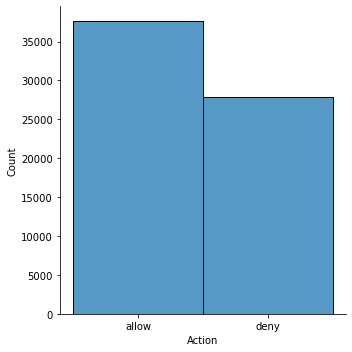

In [ ]:
# mapping custom response class
df['Action'] = df['Action'].replace(['drop', 'reset-both'], 'deny')
print(len(set(df['Action'])))

sns.displot(df, x="Action")

<a name="Testing"></a>
### Testing if 'Bytes' = ('Bytes_Sent' + 'Bytes_Received')
We can see that from a quick summing of both our sent and received byte attributes, it equals the 'bytes' amount attribute.

In [ ]:
if df['Bytes'].sum() == (df['Bytes Sent'].sum() + df['Bytes Received'].sum()):
    print('Bytes = Bytes_Sent + Bytes_Received?: '+str(True))
else: print('Bytes = Bytes_Sent + Bytes_Received?: '+str(False))

Bytes = Bytes_Sent + Bytes_Received?: True


### Testing if 'Packets' = ('pkts_sent' + 'pkts_received')
We can see that from a quick summing of both our sent and received packets attributes, it equals the 'Packets' amount attribute.

In [ ]:
if df['Packets'].sum() == (df['pkts_sent'].sum() + df['pkts_received'].sum()):
    print('Packets = pkts_sent + pkts_received?: '+str(True))
else: print('Packets = pkts_sent + pkts_received?: '+str(False))

Packets = pkts_sent + pkts_received?: True


### Density Distribution Plots

Text(0.5, 6.79999999999999, 'Packets')

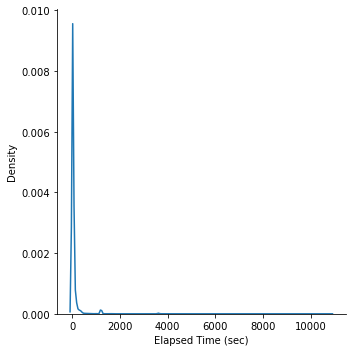

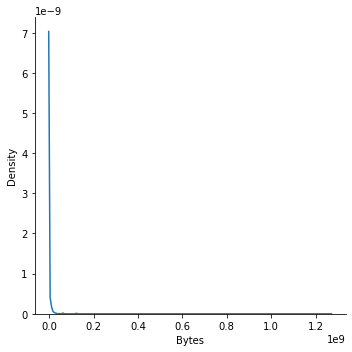

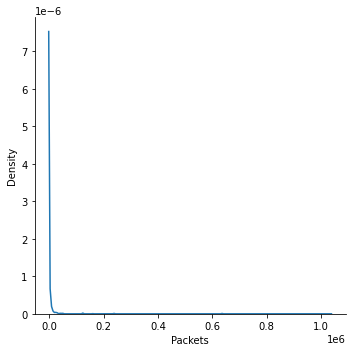

In [ ]:
# 'Elapsed Time (sec)'
sns.displot(df, x='Elapsed Time (sec)',kind='kde')
plt.xlabel('Elapsed Time (sec)')

# 'Bytes'
sns.displot(df, x='Bytes',kind='kde')
plt.xlabel('Bytes')

# 'Packets'
sns.displot(df, x='Packets',kind='kde')
plt.xlabel('Packets')

<a name="Outliers"></a>
### Visualizing Outliers

<AxesSubplot:xlabel='Packets'>

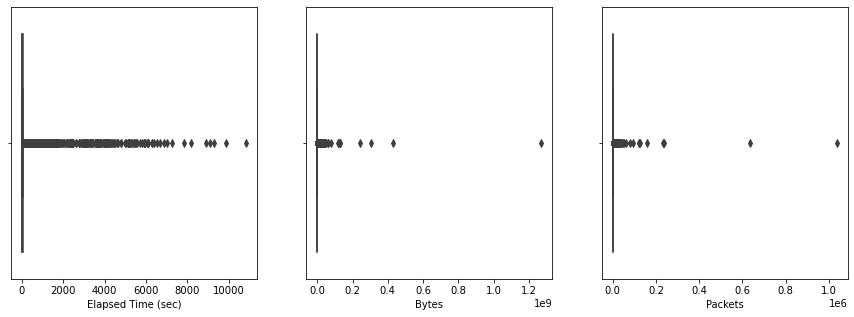

In [ ]:
# call regplot on each axes
fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(15,5))
sns.boxplot(df['Elapsed Time (sec)'],ax=ax[0])
sns.boxplot(df['Bytes'],ax=ax[1])
sns.boxplot(df['Packets'],ax=ax[2])

<a name="Correlations"></a>
### Visualizing attribute Correlations
We can observe that from our earlier analysis of checking if the sent and received attributes equal to the 'total' is significant is important because as demonstrated in the first correlation heat max, the correlations between the totals and the sent/received attributes for both 'Bytes' and 'Packets' are very high (corr > .9). However, after removing we can see that interestingly, the correlation between the total 'Packets' and total 'Bytes' is still very high (corr = .97). This is because the bytes is a property of the packet, however, for our analysis, we keep them both.

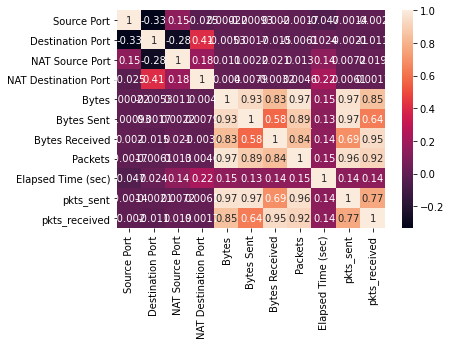

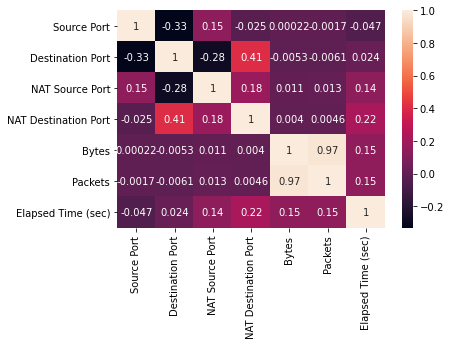

In [ ]:
corrMatrix = df[df.columns[~df.columns.isin(['Action'])]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

corrMatrix = df[df.columns[~df.columns.isin(['Action', 'Bytes Sent', 'Bytes Received', 'pkts_sent', 'pkts_received'])]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# Data Cleaning

<a name="MissingViz"></a>
## Checking for Empty Data

<AxesSubplot:>

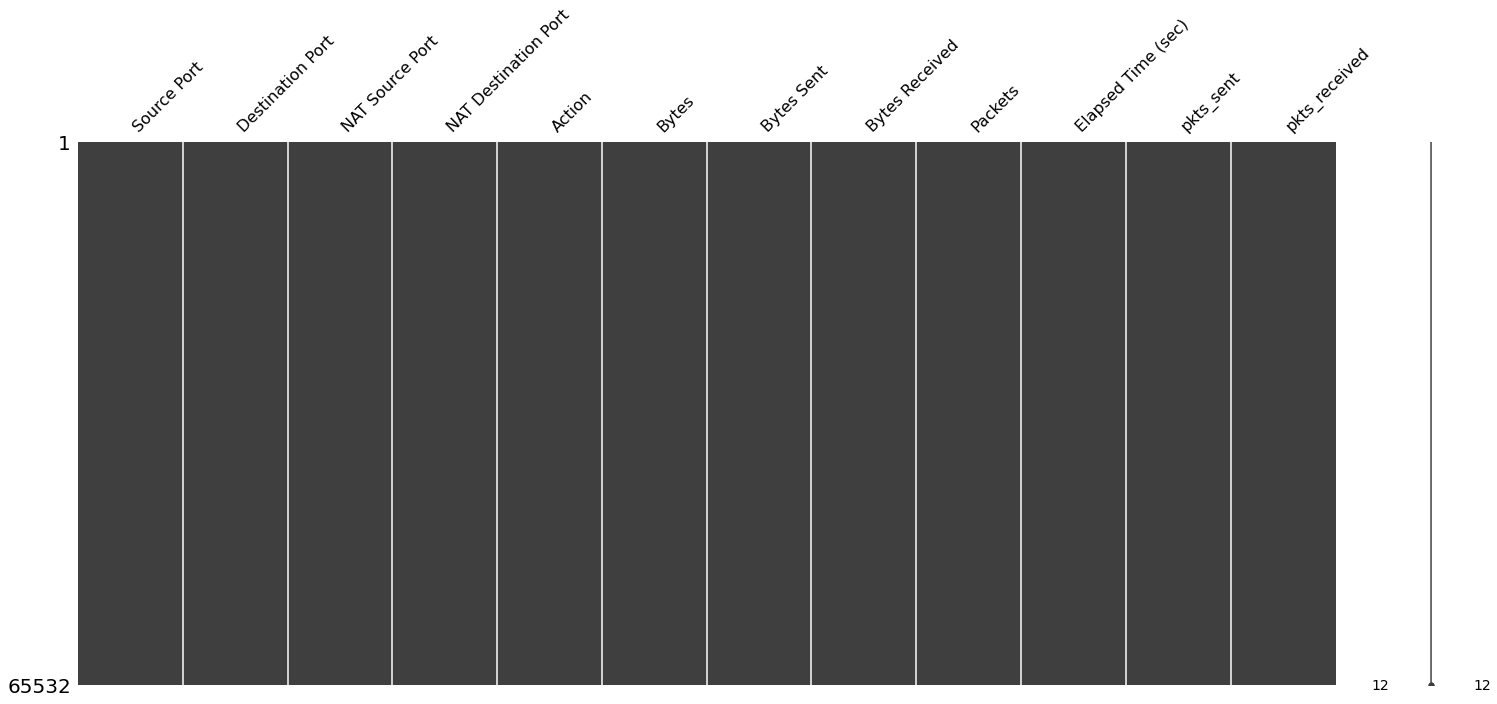

In [ ]:
msno.matrix(df)

<a name="MissingData"></a>
## Checking for Missing Data

In [ ]:
df_missing_no = df[(df['Source Port'] < 1)]
print('# of records with no ports: '+str(len(df_missing_no)))

# test # of unique values for columns if only specifiying 0 port values
for i in df.iloc[:, 0:3]:
    print(i+' unique values: '+str(df_missing_no['Source Port'].unique()))
    print('-'*80)

# selecting only non-0 port data
df = df[(df['Source Port'] > 1)]
print('# of records after no-port data removed: '+str(len(df)))

# of records with no ports: 173
Source Port unique values: [0]
--------------------------------------------------------------------------------
Destination Port unique values: [0]
--------------------------------------------------------------------------------
NAT Source Port unique values: [0]
--------------------------------------------------------------------------------
# of records after no-port data removed: 65359


<a name="Duplicates"></a>
## Checking for Duplicates

In [ ]:
def remove_dups(df, y):
    def check_fullrow_dups(df):
        dups = df.loc[:, df.columns != y].duplicated().sum()
        perc_duplicate = dups/len(df)*100
        return perc_duplicate
        #f"{dups/len(df)*100:1.2f}% of all records are considered duplicates"
        # source:
        # adapted from: https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

    if check_fullrow_dups(df) != 0:
        duplicated_rows = df[df.duplicated()]
        print(f"{check_fullrow_dups(df)}% of all records are considered duplicates")
        print('\n')
        df_dupes_removed = df.drop_duplicates(keep=False, inplace=False)
        print('# of duplicates removed: '+str(len(duplicated_rows)))
        print('\n')
        print('Response Class Duplicates: \n'+str(pd.value_counts(duplicated_rows.Action)))
        print('\n')
    else: 
        pass

    return df_dupes_removed

df = remove_dups(df, 'Action')
print('# of records remaining: '+str(len(df)))

12.5858718768647% of all records are considered duplicates


# of duplicates removed: 8226


Response Class Duplicates: 
deny     8095
allow     131
Name: Action, dtype: int64


# of records remaining: 52221


<a name="RemoveOutliers"></a>
## Removing Strong Outlier Data
As seen in our earlier visualizations of the outlier data, both the total 'Bytes' and total 'Packets' having

**Keeping only the 95% quartile**: <br>
- No. of outlier records removed: 4108<br>
- No. of records remaining: 48127<br>
- Boxplots:

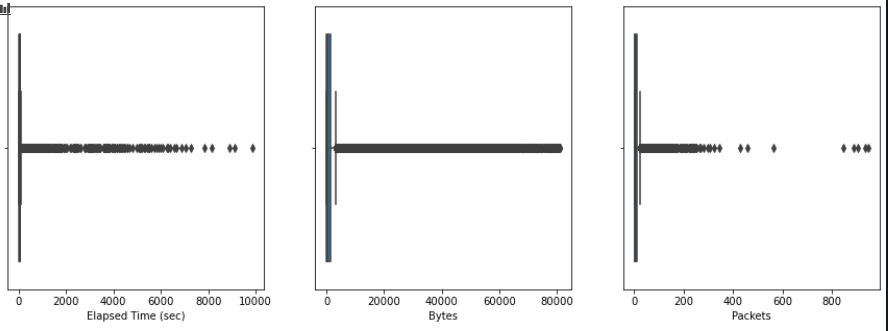


**Keeping only the 90% quartile**: <br>
- No. of outlier records removed: 5316
- No. of records remaining: 46919

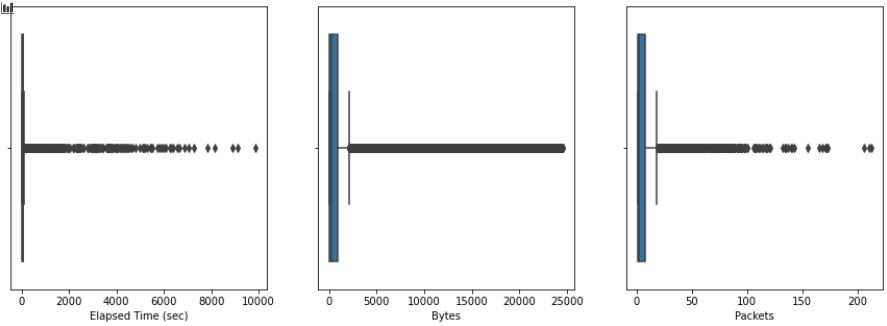


In [ ]:
def drop_outliers(df, field_name):
    iqr = 1.5*(np.percentile(df[field_name], 90) - np.percentile(df[field_name], 10))
    # df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 90))].index, inplace=True) 
    # df.drop(df[df[field_name] < (iqr + np.percentile(df[field_name], 10) - iqr)].index, inplace=True)
    df_outlier_removed = df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 90))].index, inplace=False) 
    df_outlier_removed = df_outlier_removed.drop(df_outlier_removed[df_outlier_removed[field_name] < (iqr + np.percentile(df_outlier_removed[field_name], 10) - iqr)].index, inplace=False)
    print('# of outlier records removed: '+str(len(df) - len(df_outlier_removed)))
    return df_outlier_removed

df = drop_outliers(df, 'Bytes')
print('# of records remaining: '+str(len(df)))

# Source: https://medium.com/analytics-vidhya/how-to-remove-outliers-for-machine-learning-24620c4657e8

# of outlier records removed: 5316
# of records remaining: 46905


In [ ]:
# fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(15,5))
# sns.boxplot(df['Elapsed Time (sec)'],ax=ax[0])
# sns.boxplot(df['Bytes'],ax=ax[1])
# sns.boxplot(df['Packets'],ax=ax[2])

<a name="ClassBalanceAfter"></a>
## Final DF Response Class

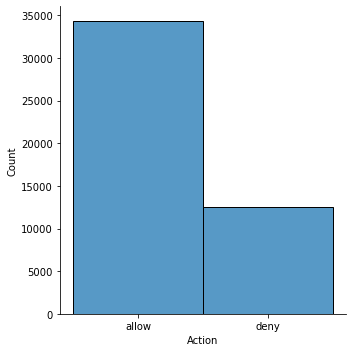

In [ ]:
sns.displot(df, x="Action")

## Removing Correlated Attributes: 'Bytes' and 'Packets'

In [ ]:
df = df[df.columns[~df.columns.isin(['Bytes', 'Packets'])]]
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes Sent', 'Bytes Received',
       'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object')

<a name="FinalDF"></a>
## Load Final DF to pickle file

In [ ]:
# saving dataframe to pickle to prevent running everything again
df.to_pickle('Firewall_df_protocol-3.pkl', protocol=3)
df.to_pickle('Firewall_df_protocol-4.pkl', protocol=4)
df.to_pickle('Firewall_df_protocol-5.pkl', protocol=5)

In [ ]:
python_version = sys.version.split(' ')[0]

if python_version > '3.8':
    df = pd.read_pickle("Firewall_df_protocol-5.pkl")
else:
    try: 
        df = pd.read_pickle("Firewall_df_protocol-4.pkl")
    except:
        df = pd.read_pickle("Firewall_df_protocol-3.pkl")

df.head(5)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes Sent,Bytes Received,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,94,83,30,1,1
1,56258,3389,56258,3389,allow,1600,3168,17,10,9
2,6881,50321,43265,50321,allow,118,120,1199,1,1
3,50553,3389,50553,3389,allow,1438,1889,17,8,7
5,51465,443,39975,443,allow,1595,2366,16,12,9


# Modeling - PyCaret Baseline Models

In [ ]:
from pycaret.classification import * 

In [ ]:
# setting up the env on entire data
classification_setup = setup(data= df, target='Action', train_size = .7, imputation_type='iterative', silent=True,verbose=False, session_id=42)

 <a name="PyCaretModels"></a>
### PyCaret Comparative Models

In [ ]:
# report models
pycaret_classification_models = compare_models()
pycaret_classification_models

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9999,1.0000,0.9998,0.9998,0.9998,0.9997,0.9997,0.1300
ada,Ada Boost Classifier,0.9998,1.0000,0.9997,0.9994,0.9995,0.9994,0.9994,0.1310
gbc,Gradient Boosting Classifier,0.9998,1.0000,0.9995,0.9995,0.9995,0.9994,0.9994,0.4220
et,Extra Trees Classifier,0.9998,0.9999,0.9995,0.9999,0.9997,0.9996,0.9996,0.1100
xgboost,Extreme Gradient Boosting,0.9998,1.0000,0.9995,0.9997,0.9996,0.9995,0.9995,0.3360
lightgbm,Light Gradient Boosting Machine,0.9998,1.0000,0.9998,0.9995,0.9997,0.9995,0.9995,0.0530
catboost,CatBoost Classifier,0.9998,1.0000,0.9997,0.9994,0.9995,0.9994,0.9994,3.1570
dt,Decision Tree Classifier,0.9997,0.9996,0.9995,0.9993,0.9994,0.9992,0.9992,0.0180
lr,Logistic Regression,0.9988,1.0000,0.9968,0.9986,0.9977,0.9969,0.9969,0.4660
nb,Naive Bayes,0.9974,0.9996,0.9930,0.9973,0.9951,0.9933,0.9933,0.0170


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### PyCaret Baseline SVM Models

NOTE: ‘rbfsvm’ and ‘gpc’ uses non-linear kernel and hence the fit time complexity is **more than quadratic**. These estimators are hard to scale on datasets with more than 10,000 samples.
Source: https://pycaret.org/classification/

In [ ]:
# SVM (linear kernel)
svm_lr = create_model('svm', fold=10)
print('SVM (Linear) Hyperparameters: '+str(svm_lr))
# SVM (RBF kernel) - TAKES too long, 'quadratic' estimation 
# svm_rbf = create_model('rbfsvm', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9760,0.0000,0.9955,0.9211,0.9569,0.9402,0.9416
1,0.9973,0.0000,0.9943,0.9954,0.9949,0.9930,0.9930
2,0.9543,0.0000,0.9909,0.8600,0.9208,0.8889,0.8934
3,0.9796,0.0000,0.9943,0.9338,0.9631,0.9490,0.9499
4,0.9753,0.0000,0.9966,0.9182,0.9558,0.9387,0.9403
5,0.9756,0.0000,0.9966,0.9192,0.9563,0.9395,0.9410
6,0.9942,0.0000,0.9920,0.9864,0.9892,0.9853,0.9853
7,0.9699,0.0000,0.9943,0.9029,0.9464,0.9255,0.9276
8,0.9817,0.0000,0.9955,0.9399,0.9669,0.9543,0.9550
9,0.9756,0.0000,0.9977,0.9184,0.9564,0.9396,0.9411


SVM (Linear) Hyperparameters: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


### SVM Baseline Model Tuned for Accuracy, AUC, Precision, F1   

In [ ]:
svm_tuned_acc = tune_model(svm_lr, optimize='Accuracy')
print(svm_tuned_acc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9942,0.0000,0.9852,0.9931,0.9892,0.9852,0.9852
1,0.9960,0.0000,0.9886,0.9966,0.9926,0.9899,0.9899
2,0.9970,0.0000,0.9943,0.9943,0.9943,0.9922,0.9922
3,0.9945,0.0000,0.9875,0.9920,0.9897,0.9860,0.9860
4,0.9979,0.0000,0.9977,0.9943,0.9960,0.9946,0.9946
5,0.9973,0.0000,0.9954,0.9943,0.9949,0.9930,0.9930
6,0.9982,0.0000,0.9943,0.9989,0.9966,0.9953,0.9953
7,0.9973,0.0000,0.9932,0.9966,0.9949,0.9930,0.9930
8,0.9979,0.0000,0.9966,0.9955,0.9960,0.9946,0.9946
9,0.9982,0.0000,0.9966,0.9966,0.9966,0.9953,0.9953


SGDClassifier(alpha=0.02, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=True,
              l1_ratio=0.3800000001, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
svm_tuned_auc = tune_model(svm_lr, optimize='AUC')
print(svm_tuned_auc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9720,0.0000,0.9977,0.9070,0.9502,0.9308,0.9328
1,0.9729,0.0000,0.9977,0.9098,0.9518,0.9330,0.9349
2,0.9887,0.0000,0.9977,0.9617,0.9794,0.9716,0.9719
3,0.9906,0.0000,0.9943,0.9711,0.9826,0.9761,0.9762
4,0.9921,0.0000,0.9989,0.9723,0.9854,0.9800,0.9801
5,0.9686,0.0000,0.9989,0.8959,0.9446,0.9228,0.9255
6,0.9918,0.0000,0.9943,0.9754,0.9848,0.9792,0.9792
7,0.9963,0.0000,0.9943,0.9921,0.9932,0.9907,0.9907
8,0.9583,0.0000,0.9977,0.8667,0.9276,0.8985,0.9029
9,0.9918,0.0000,0.9989,0.9713,0.9849,0.9792,0.9794


SGDClassifier(alpha=0.0002, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=False,
              l1_ratio=0.8900000001, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
svm_tuned_recall = tune_model(svm_lr, optimize='Recall')
print(svm_tuned_recall)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9720,0.0000,0.9977,0.9070,0.9502,0.9308,0.9328
1,0.9729,0.0000,0.9977,0.9098,0.9518,0.9330,0.9349
2,0.9887,0.0000,0.9977,0.9617,0.9794,0.9716,0.9719
3,0.9906,0.0000,0.9943,0.9711,0.9826,0.9761,0.9762
4,0.9921,0.0000,0.9989,0.9723,0.9854,0.9800,0.9801
5,0.9686,0.0000,0.9989,0.8959,0.9446,0.9228,0.9255
6,0.9918,0.0000,0.9943,0.9754,0.9848,0.9792,0.9792
7,0.9963,0.0000,0.9943,0.9921,0.9932,0.9907,0.9907
8,0.9583,0.0000,0.9977,0.8667,0.9276,0.8985,0.9029
9,0.9918,0.0000,0.9989,0.9713,0.9849,0.9792,0.9794


SGDClassifier(alpha=0.0002, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=False,
              l1_ratio=0.8900000001, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=42, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
svm_tuned_precision = tune_model(svm_lr, optimize='Precision')
print(svm_tuned_precision)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9942,0.0000,0.9852,0.9931,0.9892,0.9852,0.9852
1,0.9960,0.0000,0.9886,0.9966,0.9926,0.9899,0.9899
2,0.9970,0.0000,0.9943,0.9943,0.9943,0.9922,0.9922
3,0.9945,0.0000,0.9875,0.9920,0.9897,0.9860,0.9860
4,0.9979,0.0000,0.9977,0.9943,0.9960,0.9946,0.9946
5,0.9973,0.0000,0.9954,0.9943,0.9949,0.9930,0.9930
6,0.9982,0.0000,0.9943,0.9989,0.9966,0.9953,0.9953
7,0.9973,0.0000,0.9932,0.9966,0.9949,0.9930,0.9930
8,0.9979,0.0000,0.9966,0.9955,0.9960,0.9946,0.9946
9,0.9982,0.0000,0.9966,0.9966,0.9966,0.9953,0.9953


SGDClassifier(alpha=0.02, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=True,
              l1_ratio=0.3800000001, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
svm_tuned_f1 = tune_model(svm_lr, optimize='F1')
print(svm_tuned_f1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9942,0.0000,0.9852,0.9931,0.9892,0.9852,0.9852
1,0.9960,0.0000,0.9886,0.9966,0.9926,0.9899,0.9899
2,0.9970,0.0000,0.9943,0.9943,0.9943,0.9922,0.9922
3,0.9945,0.0000,0.9875,0.9920,0.9897,0.9860,0.9860
4,0.9979,0.0000,0.9977,0.9943,0.9960,0.9946,0.9946
5,0.9973,0.0000,0.9954,0.9943,0.9949,0.9930,0.9930
6,0.9982,0.0000,0.9943,0.9989,0.9966,0.9953,0.9953
7,0.9973,0.0000,0.9932,0.9966,0.9949,0.9930,0.9930
8,0.9979,0.0000,0.9966,0.9955,0.9960,0.9946,0.9946
9,0.9982,0.0000,0.9966,0.9966,0.9966,0.9953,0.9953


SGDClassifier(alpha=0.02, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=True,
              l1_ratio=0.3800000001, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


<a name="SVMModels"></a>
# Modeling SVM (SVC)

In [ ]:

def view_confusion_matrix(clf, X_test, y_test, y_classes):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    # Plot non-normalized confusion matrix
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                    display_labels=y_classes,
                                    cmap=plt.cm.Blues,
                                    normalize=None,ax=ax1)
    disp.ax_.set_title('Confusion Matrix')

    # Plot normalized confusion matrix
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                    display_labels=y_classes,
                                    cmap=plt.cm.Blues,
                                    normalize='true',ax=ax2)
    disp.ax_.set_title('Normalized Confusion Matrix')

    plt.show()


def view_model_metrics(clf, X_test, y_test,y_hat, y_classes):
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print('Accuracy: %.4f'% acc )
    print("Precision: %.4f"% mt.precision_score(y_test,y_hat,pos_label='allow'))
    print("Recall: %.4f"%mt.recall_score(y_test,y_hat, pos_label='allow'))
    print("F1: %.4f"%mt.f1_score(y_test,y_hat, pos_label='allow'))
    print(view_confusion_matrix(clf, X_test, y_test, y_classes))

In [ ]:
python_version = sys.version.split(' ')[0]

if python_version > '3.8':
    df = pd.read_pickle("Firewall_df_protocol-5.pkl")
else:
    try: 
        df = pd.read_pickle("Firewall_df_protocol-4.pkl")
    except:
        df = pd.read_pickle("Firewall_df_protocol-3.pkl")

df.head(5)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes Sent,Bytes Received,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,94,83,30,1,1
1,56258,3389,56258,3389,allow,1600,3168,17,10,9
2,6881,50321,43265,50321,allow,118,120,1199,1,1
3,50553,3389,50553,3389,allow,1438,1889,17,8,7
5,51465,443,39975,443,allow,1595,2366,16,12,9


<a name="Setup"></a>
### Sampling Data & Setting up Models

In [ ]:
############# Setting up Response Class #############
y_classes = df.Action.unique()
X_columns = df.columns

# remove response from df
if 'Action' in df:
    y = df['Action'].values
    del df['Action']
    X = df.values
else: pass

############# Setting up cv object #############
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

############# Train/Test Split #############
# set up train and test
for train, test in cv.split(X,y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

############# Normalizing Train/Test Data #############
scl = StandardScaler()
scl.fit(X_train)
X_train_scaled = scl.transform(X_train)
X_test_scaled = scl.transform(X_test)
print('Training Size: '+str(X_train_scaled.shape))
print('Testing Size: '+str(X_test_scaled.shape))

Training Size: (37524, 9)
Testing Size: (9381, 9)


### Default SVM Model

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy: 0.9953
Precision: 0.9994
Recall: 0.9942
F1: 0.9968


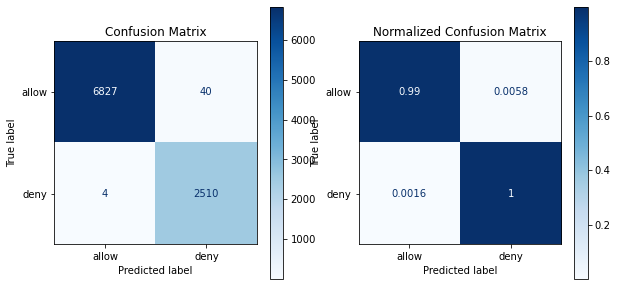

None


In [ ]:
from sklearn.svm import SVC
from sklearn import metrics as mt

svm_clf = SVC() 
print(svm_clf.get_params(deep=True))
print('='*100)

svm_clf.fit(X_train_scaled, y_train)
y_hat = svm_clf.predict(X_test_scaled) 

#view results
view_model_metrics(svm_clf, X_test_scaled, y_test, y_hat, y_classes)

<a name="LinearSVM"></a>
### Linear SVM Model

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
   coefficient                  word
0   -13.215193    Elapsed Time (sec)
1    -4.516821         pkts_received
2    -2.437213             pkts_sent
3    -2.315584       NAT Source Port
4    -2.226801  NAT Destination Port
5    -1.366505        Bytes Received
6    -0.001604            Bytes Sent
7     0.002473           Source Port
8     0.164554      Destination Port
Accuracy: 0.9988
Precision: 0.9994
Recall: 0.9990
F1: 0.9992


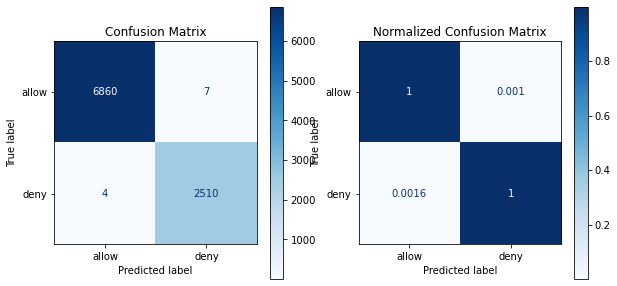

None


In [ ]:
from sklearn.svm import SVC
from sklearn import metrics as mt

svm_linear_clf = SVC(kernel='linear')
print(svm_linear_clf.get_params(deep=True))
print('='*100)

svm_linear_clf.fit(X_train_scaled, y_train)
svm_linear_clf.score(X_train_scaled, y_train)

'''
Source to get Linear SVM Feature Importance:
1. https://stackoverflow.com/questions/21260691/how-to-obtain-features-weights
2. https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
'''
feature_names = df.columns
coefs_with_fns = sorted(zip(svm_linear_clf.coef_[0], feature_names)) 
svm_linear_df=pd.DataFrame(coefs_with_fns)
svm_linear_df.columns='coefficient','word'
svm_linear_df.sort_values(by='coefficient')
print(svm_linear_df)
print('='*80)

y_hat = svm_linear_clf.predict(X_test_scaled) 

#view results
view_model_metrics(svm_linear_clf, X_test_scaled, y_test, y_hat, y_classes)

In [ ]:
coefs_with_fns

[(-13.215192977340555, 'Elapsed Time (sec)'),
 (-4.51682120780319, 'pkts_received'),
 (-2.43721293151805, 'pkts_sent'),
 (-2.3155839818780466, 'NAT Source Port'),
 (-2.2268010198625148, 'NAT Destination Port'),
 (-1.3665049564864309, 'Bytes Received'),
 (-0.0016037096468879408, 'Bytes Sent'),
 (0.002473323149792428, 'Source Port'),
 (0.16455378451756952, 'Destination Port')]

<a name="ConfusionMatrix"></a>
### GridSearch Hypertuned SVM Model

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 19.5min finished


Best params: {'C': 100, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
Best estimator: SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Model Run Duration: 0:19:31.298329
Accuracy: 0.9996
Precision: 0.9994
Recall: 1.0000
F1: 0.9997


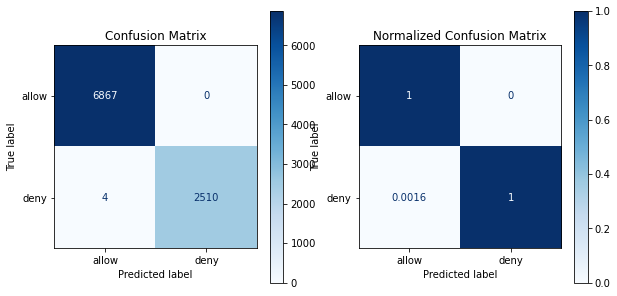

None


In [ ]:
start_time = datetime.now()
grid_params = {'kernel':('linear', 'rbf', 'sigmoid'), 
                'C':[.1, 1, 10, 100],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'degree': [3]
                }
############ For Testing only #############
# grid_params = {'kernel':['rbf'], 
#                 'C': [10],
#                 'gamma': [1],
#                 'degree': [3]
#                 }

svm = SVC()
svm_clf_grid  = GridSearchCV(svm, grid_params, refit=True, verbose=1, n_jobs = 1)
svm_clf_grid.fit(X_train_scaled, y_train)
print('Best params: '+str(svm_clf_grid.best_params_))
print('Best estimator: '+str(svm_clf_grid.best_estimator_))
end_time = datetime.now()
print('Model Run Duration: {}'.format(end_time - start_time))
print('='*100)

y_hat = svm_clf_grid.predict(X_test_scaled) 

view_model_metrics(svm_clf_grid.best_estimator_, X_test_scaled, y_test, y_hat, y_classes)

### Visualizing SVM Model

In [ ]:
# make a dataframe of the training data
df_tested_on =  df.iloc[train].copy()
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf_grid.best_estimator_.support_,:].copy()

# add back in the Response Variable Column to the pandas 
df_support['Action'] = y[svm_clf_grid.best_estimator_.support_,]
# also add it back in for the original data'
df['Action'] = y
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 964 to 65161
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           172 non-null    int64 
 1   Destination Port      172 non-null    int64 
 2   NAT Source Port       172 non-null    int64 
 3   NAT Destination Port  172 non-null    int64 
 4   Bytes Sent            172 non-null    int64 
 5   Bytes Received        172 non-null    int64 
 6   Elapsed Time (sec)    172 non-null    int64 
 7   pkts_sent             172 non-null    int64 
 8   pkts_received         172 non-null    int64 
 9   Action                172 non-null    object
dtypes: int64(9), object(1)
memory usage: 14.8+ KB


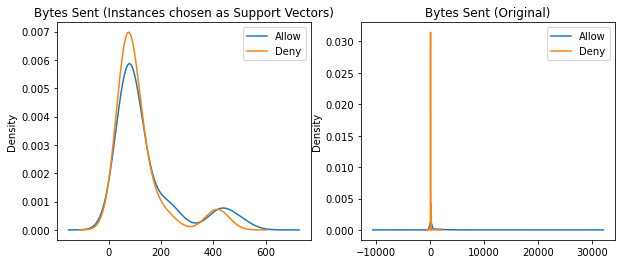

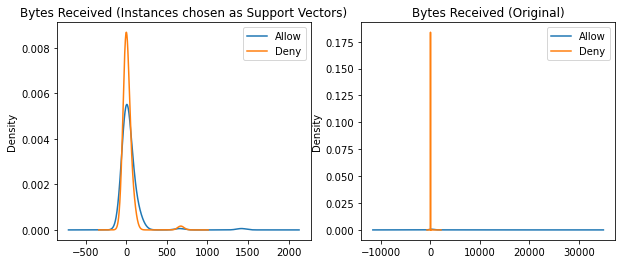

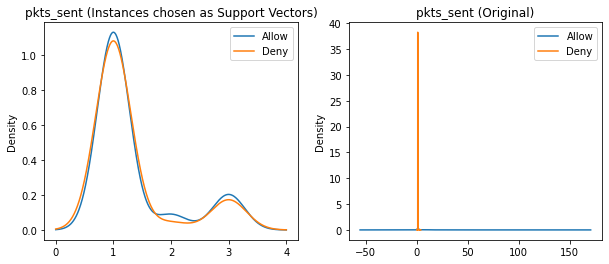

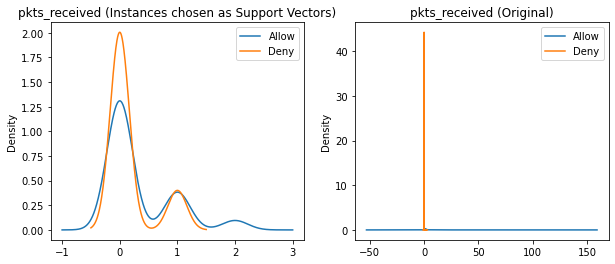

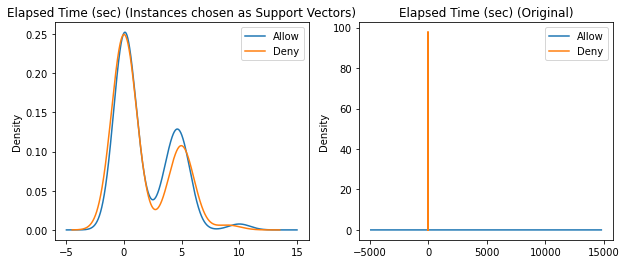

In [ ]:
# now lets see the statistics of these attributes
from matplotlib import pyplot as plt
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Action'])
df_grouped = df.groupby(['Action'])

# plot KDE of Different variables
vars_to_plot = ['Bytes Sent','Bytes Received', 'pkts_sent','pkts_received', 'Elapsed Time (sec)']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Allow','Deny'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Allow','Deny'])
    plt.title(v+' (Original)')



<a name="SGDModels"></a>
# Modeling SGD

### Barebone SGD Model

{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9959
Precision: 0.9994
Recall: 0.9950
F1: 0.9972


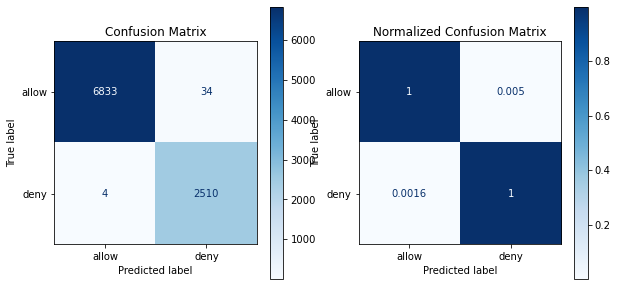

None


In [ ]:
from sklearn.linear_model import SGDClassifier

SGD_clf = SGDClassifier()
print(SGD_clf.get_params(deep=True))
print('='*100)

SGD_clf.fit(X_train_scaled, y_train)
y_hat_SGD = SGD_clf.predict(X_test_scaled)

view_model_metrics(SGD_clf, X_test_scaled, y_test, y_hat_SGD, y_classes)

<a name="TunedSGD"></a>
### Tuned SGD Model from PyCaret

{'alpha': 0.02, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.3, 'fit_intercept': True, 'l1_ratio': 0.3800000001, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9779
Precision: 0.9994
Recall: 0.9704
F1: 0.9847


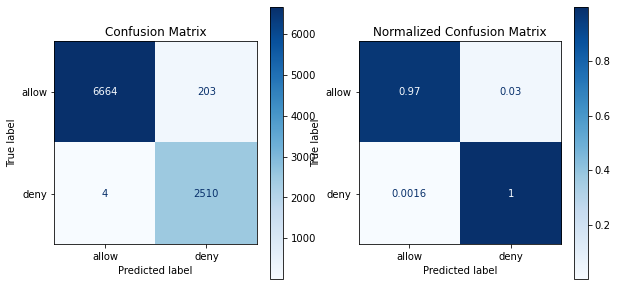

None


In [ ]:
pycaret_SGD_clf = SGDClassifier(alpha=0.02, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.3, fit_intercept=True,
              l1_ratio=0.3800000001, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
print(pycaret_SGD_clf.get_params(deep=True))
print('='*100)

pycaret_SGD_clf.fit(X_train_scaled, y_train)
y_hat_SGD_pycaret = pycaret_SGD_clf.predict(X_test_scaled)

view_model_metrics(pycaret_SGD_clf, X_test_scaled, y_test, y_hat_SGD_pycaret, y_classes)